# Chapter 9: Image Restoration


![](images/restoration.png)

In [1]:
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
import numpy.fft as nfp
from scipy import ndimage, misc, signal
from skimage import data, color, restoration, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
import numpy as np
import numpy.fft
import timeit
import warnings
warnings.filterwarnings('ignore')

## Image Deconvolution

### Inverse Filtering with FFT

In [77]:
im = 255*rgb2gray(imread('images/lena.jpg'))
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 3),
signal.gaussian(im.shape[1], 3))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) # this is our H
convolved = freq*freq_kernel # by convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur) # normalize

243.83080000000004 255.0


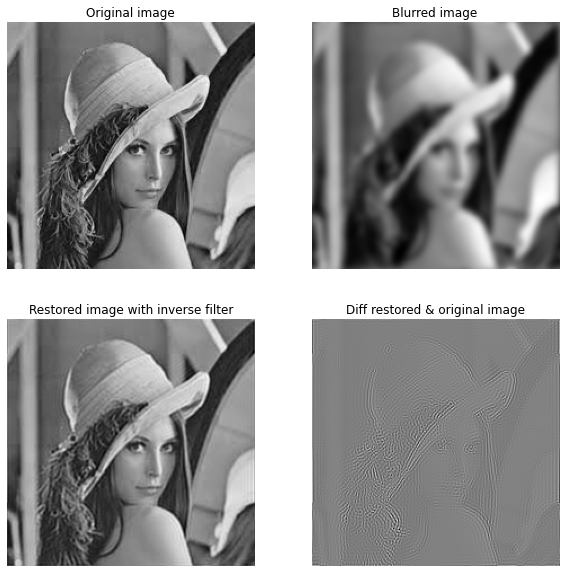

In [78]:
epsilon = 10**-6
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel) # avoid division by zero
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = 255 * im_restored / np.max(im_restored)
print(np.max(im), np.max(im_restored))
plt.figure(figsize=(10,10))
plt.gray()
plt.subplot(221), plt.imshow(im), plt.title('Original image'), plt.axis('off')
plt.subplot(222), plt.imshow(im_blur), plt.title('Blurred image'), plt.axis('off')
plt.subplot(223), plt.imshow(im_restored), plt.title('Restored image with inverse filter'), plt.axis('off')
plt.subplot(224), plt.imshow(im_restored - im), plt.title('Diff restored & original image'), plt.axis('off')
plt.show()

![](images/lena_spec.png)
![](images/lena_blur_spec.png)

In [79]:
kernel_size = 21 # a 21 x 21 motion blurred kernel
mblur_kernel = np.zeros((kernel_size, kernel_size))
mblur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
mblur_kernel = mblur_kernel / kernel_size
# expand the kernel by padding zeros

![](images/motion_blur.png)

![](images/scene_motion_blur.png)

## Deconvolution with the Wiener filter

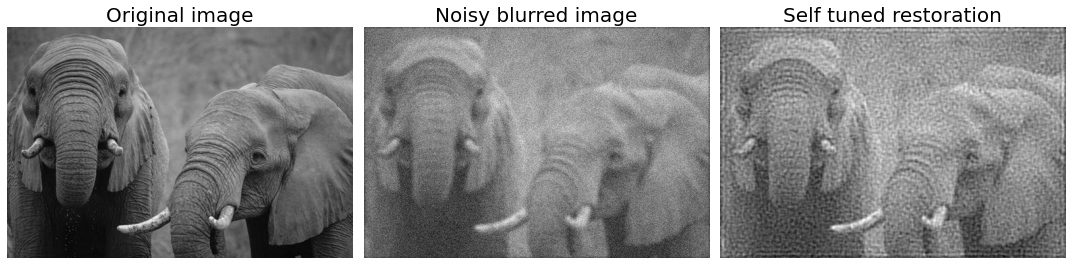

In [76]:
im = color.rgb2gray(imread('images/elephant_g.jpg'))
from scipy.signal import convolve2d as conv2
n = 7
psf = np.ones((n, n)) / n**2
im1 = conv2(im, psf, 'same')
im1 += 0.5 * im1.std() * np.random.standard_normal(im1.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)
plt.gray()
axes[0].imshow(im), axes[0].axis('off'), axes[0].set_title('Original image', size=20)
axes[1].imshow(im1), axes[1].axis('off'), axes[1].set_title('Noisy blurred image', size=20)
axes[2].imshow(im2), axes[2].axis('off'), axes[2].set_title('Self tuned restoration', size=20)
fig.tight_layout()
plt.show()

## Deconvolution with the CLEAN Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

def clean_algorithm(dirty_image, psf, gain=0.1, thresh=1e-3, max_iters=100):
    """
    Perform the CLEAN algorithm to deconvolve a dirty image.
    
    Parameters:
    dirty_image: 2D numpy array
        The observed dirty image (convolved image).
    psf: 2D numpy array
        The point spread function (PSF) or dirty beam.
    gain: float
        The gain factor for CLEAN, controls the subtraction strength.
    thresh: float
        Threshold below which to stop the iterations.
    max_iters: int
        Maximum number of iterations for the CLEAN algorithm.
    
    Returns:
    model_image: 2D numpy array
        The deconvolved image (CLEAN model).
    residual_image: 2D numpy array
        The residual dirty image after CLEAN.
    """
    
    # Initialize the residual and model image
    residual_image = dirty_image.copy()
    model_image = np.zeros_like(dirty_image)
    
    # Find the center of the PSF
    psf_center = np.array(psf.shape) // 2
    
    # Start the CLEAN iterations
    for i in range(max_iters):
        # Find the position of the maximum in the residual image
        max_pos = np.unravel_index(np.argmax(residual_image), residual_image.shape)
        max_val = residual_image[max_pos]
        
        # Stop if the maximum is below the threshold
        if max_val < thresh:
            break
        
       # Calculate boundaries for the PSF subtraction, ensuring they stay within image limits
        psf_x_min = max(max_pos[0] - psf_center[0], 0)
        psf_y_min = max(max_pos[1] - psf_center[1], 0)
        psf_x_max = min(psf_x_min + psf.shape[0], residual_image.shape[0])
        psf_y_max = min(psf_y_min + psf.shape[1], residual_image.shape[1])
        
        psf_x_min_cut = max(psf_center[0] - max_pos[0], 0)
        psf_y_min_cut = max(psf_center[1] - max_pos[1], 0)
        psf_x_max_cut = psf.shape[0] - max(0, psf_x_max - residual_image.shape[0])
        psf_y_max_cut = psf.shape[1] - max(0, psf_y_max - residual_image.shape[1])
        
        # Subtract the PSF scaled by the maximum value
        residual_image[psf_x_min:psf_x_max, psf_y_min:psf_y_max] -= \
            gain * max_val * psf[psf_x_min_cut:psf_x_max_cut, psf_y_min_cut:psf_y_max_cut]
        
        # Update the model image
        model_image[max_pos] += gain * max_val
    
    # Apply the Gaussian clean beam to the model image
    clean_beam = gaussian_filter(np.ones_like(psf), sigma=2.0)
    final_image = convolve2d(model_image, clean_beam, mode='same')
    
    # Add the residual back to the final image
    final_image += residual_image
    
    return model_image, final_image, residual_image

from skimage.color import rgb2gray
# Example usage
dirty_image = rgb2gray(plt.imread('images/sloth.png')[...,:3])  # Example dirty image
psf = gaussian_filter(np.ones((11, 11)), sigma=2)  # Example PSF

model_image, final_image, residual_image = clean_algorithm(dirty_image, psf)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(dirty_image, cmap='gray')
plt.title('Dirty Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(model_image, cmap='gray')
plt.title('Model Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title('Final Image (CLEAN)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Image Restoration with Deep Learning

### Image Denoising with NAFNet 

In [23]:
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

In [25]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python setup.py develop --no_cuda_ext

In [35]:
#import gdown
#gdown.download('https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR', "./experiments/pretrained_models/", quiet=False)
#gdown.download('https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm', "./", quiet=False)
#gdown.download('https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf', "./", quiet=False)

In [36]:
import torch
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [37]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
    fig = plt.figure(figsize=(25, 10))
    ax1 = fig.add_subplot(1, 2, 1) 
    plt.title('Input image', fontsize=16)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('NAFNet output', fontsize=16)
    ax2.axis('off')
    ax1.imshow(img1)
    ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})
      if model.opt['val'].get('grids', False):
          model.grids()
      model.test()
      if model.opt['val'].get('grids', False):
          model.grids_inverse()
      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)

In [38]:
opt_path = 'options/test/SIDD/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
opt['num_gpu'] = 0 # run on CPU
NAFNet = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x000001FD6F00F440>


2025-08-03 01:45:29,203 INFO: Model [ImageRestorationModel] is created.


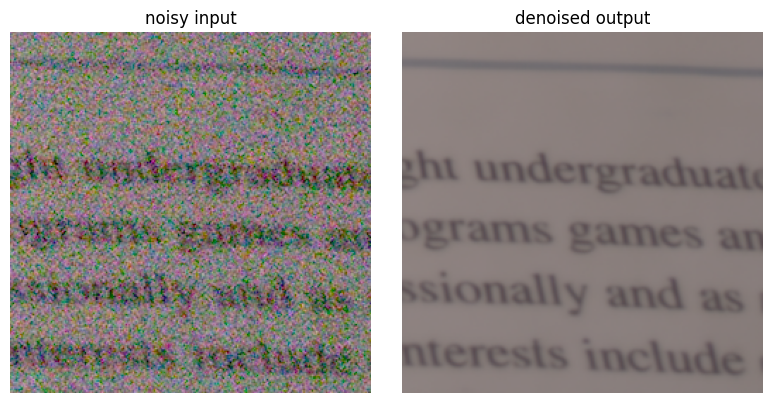

In [42]:
input_path = '../images/btext.png'
output_path = '../images/btext_out.png'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(img_input), plt.axis('off'), plt.title('noisy input')
plt.subplot(122), plt.imshow(img_output), plt.axis('off'), plt.title('denoised output')
plt.tight_layout()
plt.show()

In [ ]:
%cd ../../
!dir

### Guided Image Restoration with InstructIR

In [6]:
! git clone https://github.com/mv-lab/InstructIR
%cd InstructIR

In [13]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random

from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

import warnings
warnings.filterwarnings('ignore')

CONFIG     = "configs/eval5d.yml"
USE_WANDB  = False
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
    
class InstuctIR_Model: 

    def __init__(self):
        
        seed_everything(SEED=SEED)
        torch.backends.cudnn.deterministic = True    
    
        # parse config file
        with open(os.path.join(CONFIG), "r") as f:
            config = yaml.safe_load(f)
        
        self.cfg = dict2namespace(config)
    
        self.model = instructir.create_model(input_channels = self.cfg.model.in_ch, width=self.cfg.model.width, enc_blks = self.cfg.model.enc_blks, 
                                    middle_blk_num = self.cfg.model.middle_blk_num, dec_blks = self.cfg.model.dec_blks, txtdim=self.cfg.model.textdim)
        self.model = self.model.to(DEVICE)
        self.load_models()

    def load_models(self):
        
        # LOAD IMAGE MODEL
        assert MODEL_NAME, "Model weights required for evaluation"
        
        #print ("IMAGE MODEL CKPT:", MODEL_NAME)
        self.model.load_state_dict(torch.load(MODEL_NAME, map_location = torch.device(DEVICE)), strict=True)
        
        nparams   = count_params (self.model)
        #print ("Loaded weights!", nparams / 1e6)
        
        # LOAD LANGUAGE MODEL
        if self.cfg.model.use_text:
            os.environ["TOKENIZERS_PARALLELISM"] = "false"
        
            LMODEL = self.cfg.llm.model
            self.language_model = LanguageModel(model=LMODEL)
            self.lm_head = LMHead(embedding_dim=self.cfg.llm.model_dim, hidden_dim=self.cfg.llm.embd_dim, num_classes=self.cfg.llm.nclasses)
            self.lm_head = self.lm_head.to(DEVICE)
            lm_nparams   = count_params (self.lm_head)
        
            #print ("LMHEAD MODEL CKPT:", LM_MODEL)
            self.lm_head.load_state_dict(torch.load(LM_MODEL, map_location = torch.device(DEVICE)), strict=True)
            #print ("Loaded weights!")
        
        else:
            LMODEL = None
            self.language_model = None
            self.lm_head = None
            lm_nparams = 0
        
        #torch.cuda.empty_cache()
        #torch.cuda.reset_peak_memory_stats()
    
    def restore_img (self, img, prompt, load_img_file=True):
        
        image = load_img(img) if load_img_file else (img / img.max()).astype(np.float32)
        y = torch.Tensor(image).permute(2,0,1).unsqueeze(0).to(DEVICE)
    
        # Get the text embedding (and predicted degradation class)
        lm_embd = self.language_model(prompt)
        lm_embd = lm_embd.to(DEVICE)
        text_embd, deg_pred = self.lm_head (lm_embd)
        text_embd = text_embd.to(DEVICE)

        # Forward pass
        x_hat = self.model(y, text_embd)
    
        # convert the restored image <x_hat> into a np array
        restored_image = x_hat[0].permute(1,2,0).cpu().detach().numpy()
        restored_image = np.clip(restored_image, 0. , 1.)
        
        return image, restored_image

cpu


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


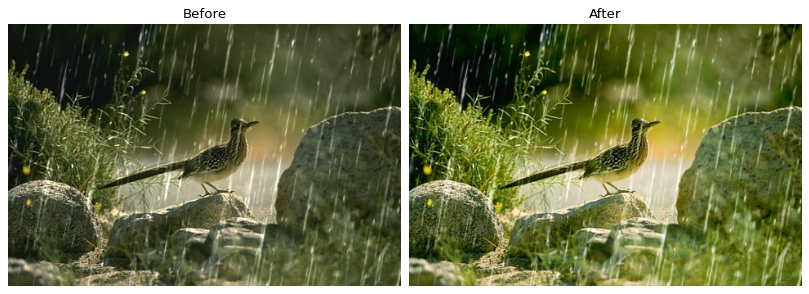

In [14]:
IMG    = "images/rain-020.png" 
PROMPT = "Retouch the picture as a professional photographer please"

ins = InstuctIR_Model()
image, restored_image = ins.restore_img(IMG, PROMPT )
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

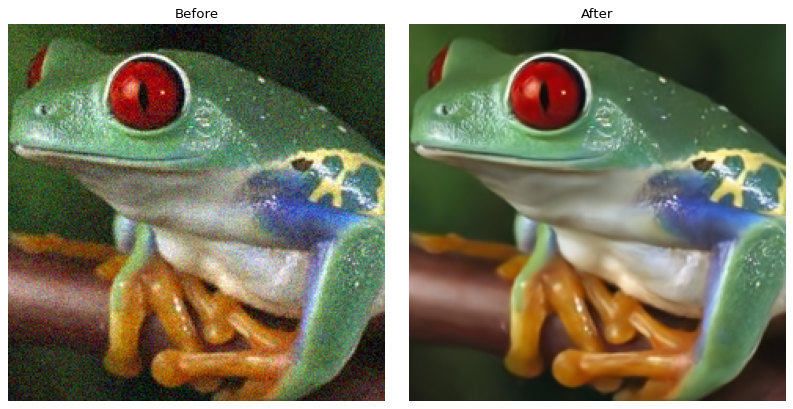

In [15]:
IMG    = "images/frog.png" # from RealSRSet
PROMPT = "Can you remove the little dots in the image? is very unpleasant"
image, restored_image = ins.restore_img(IMG, PROMPT )
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

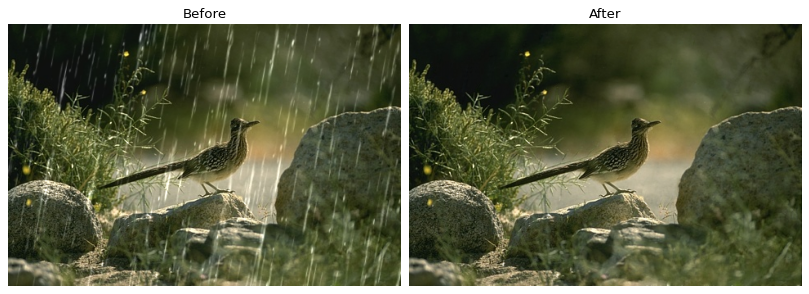

In [16]:
IMG    = "images/rain-020.png"
PROMPT = "I love this photo, could you remove the raindrops? please keep the content intact"
image, restored_image = ins.restore_img(IMG, PROMPT )
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

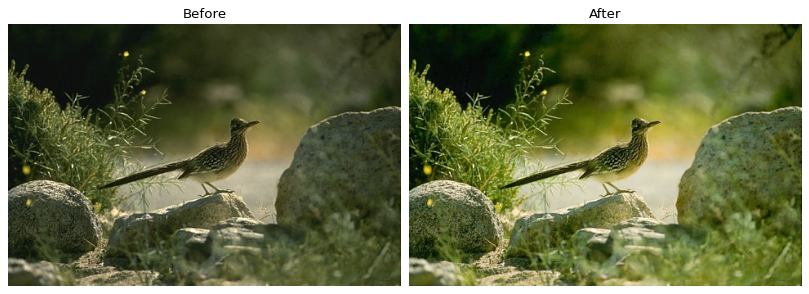

In [17]:
PROMPT = "Can you make it look stunning? like a professional photo"
image, restored_image = ins.restore_img(restored_image, PROMPT, False)
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

### Demonstration with `gradio`

In [18]:
ins = InstuctIR_Model()

In [ ]:
import gradio as gr
import numpy as np

def restore_image(image, prompt):
    image, restored_image = ins.restore_img(image, prompt, False)
    return (255*restored_image / restored_image.max()).astype('uint8')

# Create a Gradio interface
iface = gr.Interface(fn=restore_image, inputs=['image', 'text'], outputs='image')
iface.launch()

In [56]:
%cd ../../
!dir

## Stable Diffusion-based Inpainting (DeepFill)

In [ ]:
#! pip install controlnet-aux diffusers transformers accelerate torch torchvision

from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
).to(DEVICE)

image = Image.open("images/me_child_damaged.jpg").convert("RGB")
mask_image = Image.open("images/me_child_inpaint_mask.jpg").convert("L")

output = pipe(prompt="a beautiful landscape", image=image, mask_image=mask_image).images[0]
output.save("images/inpainted_output.png")

## Questions

1. Plot the frequency spectrum of an image, a Gaussian kernel, and the image
obtained after convolution in the frequency domain, in 3D (the output should be
like the surfaces shown in the sections) using the mpl_toolkits.mplot3d
module. (Hint: the `np.meshgrid()` function will come in handy for the surface
plot). Repeat the exercise for the inverse filter too.
2. Add some random noise to the lena image, blur the image with a Gaussian
kernel, and then try to restore the image using an inverse filter, as shown in the
corresponding example. What happens and why?
3. Use `scipy.signal`'s `fftconvolve()` function to apply a Gaussian blur on a color
image in the frequency domain.
4. Use the `fourier_uniform()` and `fourier_ellipsoid()` functions of the
`ndimage` module of `scipy` to apply LPFs with box and ellipsoid kernels, respectively, on an image in the frequency domain.

## Further reading / References

1. https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf
2. http://www.aip.de/groups/soe/local/numres/bookcpdf/c13-3.pdf
3. http://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter4.pdf
4. https://web.stanford.edu/class/ee367/slides/lecture6.pdf
5. https://pdfs.semanticscholar.org/presentation/50e8/fb095faf6ed51e03c85a2fcb7eb1ae1b1009.pdf
6. http://www.robots.ox.ac.uk/~az/lectures/ia/lect2.pdf